In [1]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import json
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import scipy.io as sio


In [2]:
dataset_path = r"Data/genres_original"
json_path = "data.json"
SAMPLE_RATE = 22050
DURATION = 29
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
hop_length = 512
n_mels = 100
expected_length = math.ceil(SAMPLES_PER_TRACK/hop_length)

In [3]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    axs[0].grid()

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    axs[1].grid()

    plt.show()

In [31]:
filepath = "Data/genres_original/rock/rock.00001.wav"
signal,sr = librosa.load(filepath,sr=SAMPLE_RATE)
spectrum = librosa.feature.melspectrogram(y = signal,
                                      sr = sr,
                                      fmax = 4000,
                                      n_mels = 100,
                                      power = 2,
                                      hop_length = hop_length)

mfcc = librosa.feature.mfcc(y = signal,
                            sr = sr,
                            n_mfcc = 20,
                            power = 2,
                            hop_length = hop_length)


(20, 1293)


C:\Users\georg\AppData\Local\Temp\ipykernel_12672\3214178008.py:8: RuntimeWarning: invalid value encountered in log
  img = librosa.display.specshow(np.log(mfcc), x_axis='time', ax=ax[1])


[Text(0.5, 1.0, 'MFCC')]

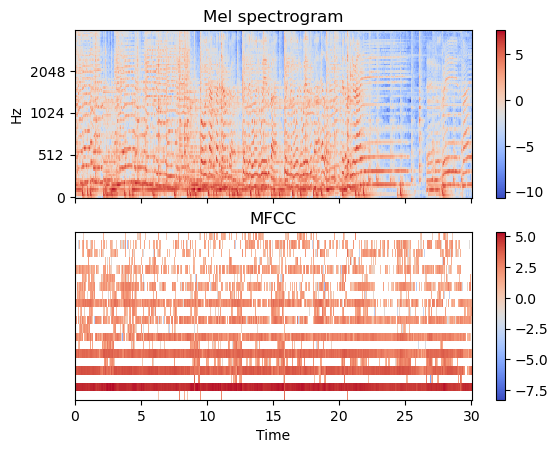

In [38]:
print(np.array(mfcc).shape)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(np.log(spectrum),  x_axis='time', y_axis='mel', fmax=4000, ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(np.log(mfcc), x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')


In [36]:
def save_mfcc(dataset_path, json_path, n_mfcc=20, n_fft=2048,
             hop_length=512, num_segments=1):
    # Data storage dictionary

    data = {
        "mapping": [],
        "mfcc": np.zeros((0, n_mfcc, expected_length)),
        "labels": []
    }
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)

                    signal = signal[0:SAMPLES_PER_TRACK-1]

                    spectrum = librosa.feature.mfcc(y = signal,
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)
                    # spectrum = librosa.feature.melspectrogram(y = signal,
                    #                                           sr = sr,
                    #                                           fmax = 2000,
                    #                                           n_mels = n_mels,
                    #                                           power = 1)
                    spectrum = np.array(spectrum)
                    # for i in range(spectrum.shape[0]):
                    #     spectrum[i,:] = ( spectrum[i,:] - np.mean(spectrum[i,:]) )/np.max(np.abs(spectrum[i,:]))

                    # mfcc = mfcc.T
                    # store mfcc if it has expected length
                    spectrum = spectrum[np.newaxis, ...]
                    data["mfcc"]   = np.append(data["mfcc"], spectrum, axis=0)
                    data["labels"].append(i-1)
                    print(f"{file_path}")

    # with open(json_path,"w") as f:
    #     json.dump(data,f,indent=4)

    #save as .mat instead
    data["labels"] = np.array(data["labels"])
    sio.savemat("data.mat", data)


In [ ]:
data = save_mfcc(dataset_path,json_path,num_segments=1)
clear_output()